# Generación de geometrías y análisis geoespacial

#### Importación de las librerías necesarias, algunas de ellas para análisis geoespacial

In [1]:
import pandas as pd
import numpy as np
import csv

#Dependencies: conda install -c conda-forge fiona shapely pyproj rtree
import geopandas as gpd # geopandas.org for more information.
from shapely.geometry import Point

#Data visualization
import seaborn as sns
sns.set(style="whitegrid")

#### Lectura ficheros, transformación y generación del Dataframe para el Modelo

Se lee el CSV procedente del script de generación del model final, el cual está agrupado por Contaminante e Id único (defunción).

In [2]:
df_model = pd.read_csv('../data/csv/model_csv/df_model.csv', sep=';', encoding= 'utf-8',  compression='gzip', index_col=False)

In [3]:
df_model.shape

(85526, 26)

In [4]:
pd.options.display.max_columns = None

In [5]:
df_model['Id'].nunique()

52806

Vemos todas las variables y su tipo

In [6]:
df_model.dtypes

Unnamed: 0               int64
Id                       int64
ProvinciaReside          int64
MunicipioReside          int64
Sexo                     int64
AnioCumplidos            int64
TamanioMuniResi          int64
CausaMortaReduc          int64
NivelEstudios            int64
Poblacion               object
Provincia               object
Comunidad               object
Latitud                float64
Longitud               float64
Habitantes               int64
Hombres                  int64
Mujeres                  int64
CodigoPRTR               int64
LongitudE              float64
LatitudE               float64
Contaminante            object
total_anios_Expo_Id      int64
Total_Kg_expo          float64
COD_3                   object
Descripcion_Cod_3       object
target                   int64
dtype: object

In [7]:
df_model.drop(['Unnamed: 0'], axis=1, inplace=True) #Borramos columnas innecesarias

Comprobamos si alguna columna tiene valores NA para depurarlos

In [8]:
df_model.isnull().any()

Id                     False
ProvinciaReside        False
MunicipioReside        False
Sexo                   False
AnioCumplidos          False
TamanioMuniResi        False
CausaMortaReduc        False
NivelEstudios          False
Poblacion              False
Provincia              False
Comunidad              False
Latitud                False
Longitud               False
Habitantes             False
Hombres                False
Mujeres                False
CodigoPRTR             False
LongitudE              False
LatitudE               False
Contaminante           False
total_anios_Expo_Id    False
Total_Kg_expo          False
COD_3                  False
Descripcion_Cod_3      False
target                 False
dtype: bool

### Generación de la Geometrías

Se combinan las columnas Longitud y Latitud para crear con Shapely un objeto Geometry de tipo "POINT", 
esto se hará para las localizaciones de los fallecimiento y los puntos de Emisión de contaminantes.

Nota** Este proceso tarda unos minutos

In [9]:
df_model['geometry_death'] = df_model.apply(lambda x: Point((float(x.Longitud), float(x.Latitud))), axis=1)
df_model['geometry_focalEmission'] = df_model.apply(lambda x: Point((float(x.LongitudE), float(x.LatitudE))), axis=1)

Vemos todos los campos y en especial las geometrías creadas tipo POINT

In [10]:
df_model.head(1000)

,Id,ProvinciaReside,MunicipioReside,Sexo,AnioCumplidos,TamanioMuniResi,CausaMortaReduc,NivelEstudios,Poblacion,Provincia,Comunidad,Latitud,Longitud,Habitantes,Hombres,Mujeres,CodigoPRTR,LongitudE,LatitudE,Contaminante,total_anios_Expo_Id,Total_Kg_expo,COD_3,Descripcion_Cod_3,target,geometry_death,geometry_focalEmission
0,28355,11,22,1,62,4,18,9,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,C34,TUMOR_MALIGNO_DE_LOS_BRONQUIOS_Y_DEL_PULMON,1,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
1,28360,11,22,6,81,4,35,1,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,C80,TUMOR_MALIGNO_DE_SITIOS_NO_ESPECIFICADOS,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
2,28367,11,22,6,69,4,67,2,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,J22,INFEC_AGUD_NO_ESPECIFICADA_DE_LAS_VIAS_RESPIRA...,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
3,28370,11,22,6,49,4,58,6,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,I26,EMBOLIA_PULMONAR,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
4,28387,11,22,6,90,4,31,1,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,C67,TUMOR_MALIGNO_DE_LA_VEJIGA_URINARIA,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
5,28392,11,22,6,87,4,26,6,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,C56,TUMOR_MALIGNO_DEL_OVARIO,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
6,28432,11,22,1,59,4,33,8,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,C71,TUMOR_MALIGNO_DEL_ENCEFALO,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
7,28435,11,22,1,73,4,64,3,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,J44,OTRAS_ENFERMEDADES_PULMONARES_OBSTRUCTIVAS_CRO...,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
8,28446,11,22,6,86,4,45,2,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,E05,TIROTOXICOSIS_[_HIPERTIROIDISMO_],0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)
9,28455,11,22,6,92,4,58,2,Línea de la Concepción (La),Cádiz,Andalucía,36.16118,-5.348256,64595,31947,32648,534,-5.385775,36.181181,Dióxido de carbono (CO2),5,7.319000e+09,I26,EMBOLIA_PULMONAR,0,POINT (-5.348256 36.16118),POINT (-5.385775499999999 36.18118120000001)


Utilizamos geopandas para generar el dataframe geoespacial

In [11]:
geodf1 = gpd.GeoDataFrame(df_model, geometry='geometry_death')
geodf2 = gpd.GeoDataFrame(df_model, geometry='geometry_focalEmission')

Definimos el CRS por defecto según las coordenadas que geocodificamos del google en la etapa primera de geocodificación.
Establecemos el 4326 según EPSG (WGS84)

In [12]:
geodf1.crs = {'init' :'epsg:4326'}
geodf2.crs = {'init' :'epsg:4326'}

Re-proyectamos las coordenadas a EPSG::32630 (WGS84 UTM30N) para luego poder realizar cálculos

Nota** este proceso tarda unos minutos

In [13]:
geodf1= geodf1.to_crs({'init': 'epsg:32630'})
geodf2= geodf2.to_crs({'init': 'epsg:32630'})

Vemos el nombre de la capa activa 'geometry' para el geoDataframe segundo

In [14]:
geodf2.geometry.name

'geometry_focalEmission'

Podemos ver los límites mínimos y máximos para la Longitud (X) y Latitud (Y)

In [15]:
geodf1.geometry.total_bounds

array([-809630.18620991, 3174367.03653209, 1121363.98328194,
       4833510.85541308])

In [16]:
len(geodf1)

85526

Se genera antes la columna Distance en el geodataframe primero, en la cual se almacenará la distancia entre los dos puntos

In [17]:
geodf1.loc[:,'Distance']=''

Se itera sobre la Geometría de uno de los Dataframes y se obtiene mediante el método "distance" las distancias entre puntos

Nota** Este proceso tarda unos minutos

In [18]:
for x,point in enumerate(geodf1.geometry):
    geodf1.Distance.at[x] = geodf1.geometry.iloc[x].distance(geodf2.geometry.iloc[x])

In [19]:
geodf1['Distance'].unique()

array([4040.455606617346, 3172.4454127231757, 7975.158617590573,
       8417.845030004848, 6926.549882586504, 6993.158853125536,
       3838.7418531660587, 5657.916857931292, 736.0464063451625,
       3094.4931464741912, 5077.408490458312, 3402.5766914803003,
       5435.453476710737, 5899.058735957333, 4530.592240603125,
       8121.892124935635, 7687.848937563832, 7444.7024815269,
       5350.9855806844225, 6254.424616303338, 6633.941505294799,
       1334.2577226014587, 7147.382894106948, 758.2205670584949,
       63.72621313449774, 349.1192835988758, 306.26321013732485,
       3849.0708090861995, 4245.187245879672, 5528.574324601846,
       3367.127666265426, 2091.6096260422873, 598.847048853157,
       2271.8974145787997, 29.291808260109857, 17.34160745388187,
       2044.565812607257, 4316.375949672578, 5705.594923508533,
       830.2127590916971, 5376.155280289309, 5858.446914508691,
       5739.102680461963, 7293.0355641236065, 193.680244870989,
       9319.946819752859, 1589.8

Redondeamos los decimales de la distancia, no queremos tanto detalle

In [20]:
geodf1['Distance'] = geodf1['Distance'].apply(lambda x: int(x))

In [21]:
geodf1.sample(10000).sort_values(by='Distance', ascending=True)

,Id,ProvinciaReside,MunicipioReside,Sexo,AnioCumplidos,TamanioMuniResi,CausaMortaReduc,NivelEstudios,Poblacion,Provincia,Comunidad,Latitud,Longitud,Habitantes,Hombres,Mujeres,CodigoPRTR,LongitudE,LatitudE,Contaminante,total_anios_Expo_Id,Total_Kg_expo,COD_3,Descripcion_Cod_3,target,geometry_death,geometry_focalEmission,Distance
17242,61005,12,82,6,88,2,16,2,Nules,Castellón/Castelló,Valencia,39.85245,-0.158631,13490,6756,6734,602,-0.158832,39.852433,Dióxido de carbono (CO2),1,2.870000e+08,C24,TUMOR_MALIGNO_DE_OTRAS_PARTES_Y_DE_LAS_NO_ESPE...,0,POINT (743077.6684917456 4415244.906229503),POINT (-0.158832 39.85243320000001),17
17233,60850,12,82,6,72,2,23,4,Nules,Castellón/Castelló,Valencia,39.85245,-0.158631,13490,6756,6734,602,-0.158832,39.852433,Dióxido de carbono (CO2),1,2.870000e+08,C50,TUMOR_MALIGNO_DE_LA_MAMA,0,POINT (743077.6684917456 4415244.906229503),POINT (-0.158832 39.85243320000001),17
17223,60670,12,82,1,89,2,28,3,Nules,Castellón/Castelló,Valencia,39.85245,-0.158631,13490,6756,6734,602,-0.158832,39.852433,Dióxido de carbono (CO2),1,2.870000e+08,C61,TUMOR_MALIGNO_DE_LA_PROSTATA,0,POINT (743077.6684917456 4415244.906229503),POINT (-0.158832 39.85243320000001),17
17126,69762,13,71,6,91,4,67,3,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,J98,OTROS_TRASTORNOS_RESPIRATORIOS,0,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
17176,70151,13,71,1,74,4,67,2,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,J84,OTRAS_ENFERMEDADES_PULMONARES_INTERSTICIALES,0,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
17045,68751,13,71,6,63,4,26,4,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,C56,TUMOR_MALIGNO_DEL_OVARIO,0,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
17037,68677,13,71,1,90,4,31,2,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,C67,TUMOR_MALIGNO_DE_LA_VEJIGA_URINARIA,0,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
17123,69742,13,71,1,72,4,18,5,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,C34,TUMOR_MALIGNO_DE_LOS_BRONQUIOS_Y_DEL_PULMON,1,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
17036,68667,13,71,1,60,4,18,2,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,C34,TUMOR_MALIGNO_DE_LOS_BRONQUIOS_Y_DEL_PULMON,1,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
17046,68756,13,71,1,82,4,18,3,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,C34,TUMOR_MALIGNO_DE_LOS_BRONQUIOS_Y_DEL_PULMON,1,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29


#### Cargamos el shape de municipios descargado de la página de Datos abiertos de ESRI (datos del IGN)

In [22]:
municipios = gpd.read_file('../data/shapes/municipios.ign/Municipios_IGN.shp')

In [23]:
municipios.head()

,OBJECTID,INSPIREID,NATCODE,CODNUT1,CODNUT2,CODNUT3,NAMEUNIT,CODIGOINE,geometry
0,3001,ES.IGN.SIGLIM34073434161,34073434161,ES4,ES41,ES414,San Cristóbal de Boedo,34161,"POLYGON ((-4.37610841038301 42.5484911697205, ..."
1,3002,ES.IGN.SIGLIM34073434163,34073434163,ES4,ES41,ES414,San Mamés de Campos,34163,"POLYGON ((-4.58329842028732 42.3641575497321, ..."
2,3003,ES.IGN.SIGLIM34073434168,34073434168,ES4,ES41,ES414,Santa Cruz de Boedo,34168,"POLYGON ((-4.4222077804343 42.5457855802628, -..."
3,3004,ES.IGN.SIGLIM34073434169,34073434169,ES4,ES41,ES414,Santervás de la Vega,34169,"POLYGON ((-4.89999934973616 42.4506824300329, ..."
4,3005,ES.IGN.SIGLIM34073434171,34073434171,ES4,ES41,ES414,Santibáñez de la Peña,34171,"POLYGON ((-4.80106393041723 42.7464759601427, ..."


Asignamos el CRS de los municipios al dataframe de geopandas, para asegurarnos en la transformación

In [24]:
geodf1 = geodf1.to_crs(municipios.crs)

Creamos primero el plot de municipios como base

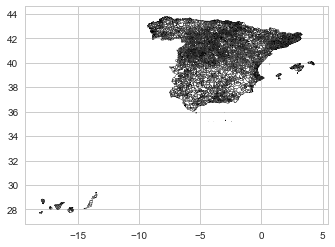

In [25]:
base = municipios.plot(color='white', edgecolor='black')

In [26]:
geodf1.plot(ax=base, marker='o', color='red', markersize=10)
#geodf2.plot(ax=base, marker='o', color='blue', markersize=10)

Vamos a utilizar matplolib para plotearlo mejor

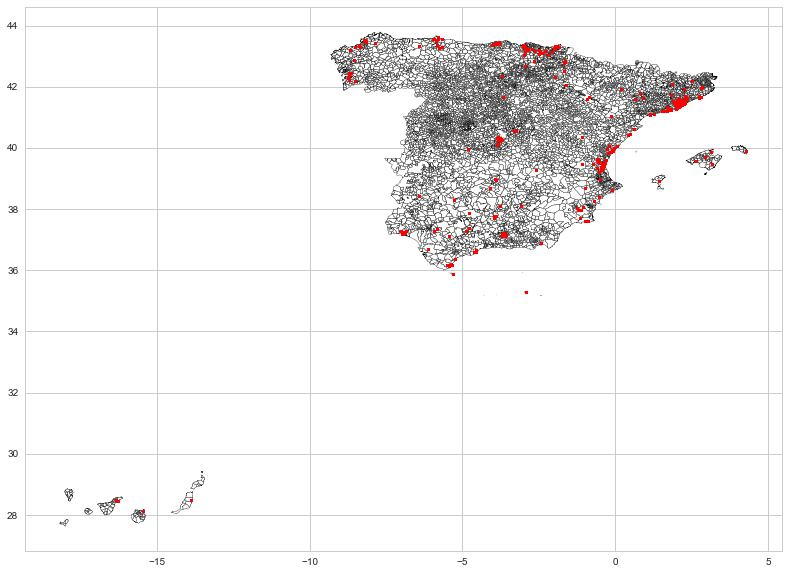

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10), sharey=True)

ax.set_aspect('equal')

municipios.plot(ax=ax, color='white', edgecolor='black')
geodf1.plot(ax=ax, marker='o', color='red', markersize=5, legend=True)

plt.show()

Salvamos a CSV antes de salvar a shape file

In [28]:
geodf1.to_csv('../data/csv/model_csv/df_model_geom.csv', sep=';', encoding= 'utf-8',  compression='gzip')

Para salvar a shape file necesitamos sólo una geometría por fichero... sólo nos quedamos con las columnas necesarias para el estudio.

In [29]:
#Nos quedamos solo con las columnas que nos interesan para el estudio geospacial.

cols_of_interest_1= ['Id','ProvinciaReside', 'MunicipioReside','Sexo', 'AnioCumplidos','TamanioMuniResi','NivelEstudios',\
        'Poblacion', 'Provincia', 'Comunidad', 'Latitud', 'Longitud', 'Habitantes', 'Hombres', 'Mujeres', \
        'LongitudE','LatitudE','Contaminante','total_anios_Expo_Id','Total_Kg_expo','COD_3','Descripcion_Cod_3',\
         'geometry_death', 'Distance', 'target'] 

cols_of_interest_2= ['Id','LongitudE','LatitudE','geometry_focalEmission']   


geodf1 = geodf1[cols_of_interest_1]          
geodf2 = geodf2[cols_of_interest_2]                              

#### Salvamos a shape el geoDataframe con las distancias, luego lo utilizaremos para la regresion espacial

In [30]:
pathname1='../data/shapes/Deaths/Deaths2015.shp'
pathname2= '../data/shapes/Emissions/Emissions2015.shp'

Este proceso puede durar varios minutos... comentar una vez salvados los shape

In [31]:
geodf1.to_file(pathname1, driver="ESRI Shapefile")
geodf2.to_file(pathname2, driver="ESRI Shapefile")